In [28]:
''' iPython script for the Multi-Chromatic Stimulator Project

Source : https://github.com/BadenLab/Multi-Chromatic-Stmulator
This project is Open Source licensed, released under CERN OHL v1.2

by M.J.Y. Zimmermann & P.Bartel, 2019.04.24
Baden Lab, CRPC, School of Life Sciences, University of Sussex, United Kingdom
'''

from IPython.display import Image,HTML,display
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors
from matplotlib.pyplot import figure
from scipy.signal import savgol_filter as savgol
import seaborn as sns
sns.set_style('whitegrid')
from scipy.optimize import minimize
import scipy as scipy
from scipy import stats, integrate
Image(url= "https://badenlabdotorg.files.wordpress.com/2018/03/cropped-lab-logo_banner21.png", width=1000, height=1000)

In [32]:
# Setting global parameters



''' Spectrometer recording traces, the directory has to be modified to its new location '''
os.chdir(r"C:\Users\Maxime\Documents\GitHub\Multi-Chromatic-Stimulator\Spectrum Calibration\Spectrometer Recording") 


''' Here we defined the max absorbance for each cone opsin present in the Zebrafish. The following values are taken from 
Allison et al (Visual pigment composition in zebrafish:Evidence for a rhodopsin–porphyropsin interchange system, 2004)    '''
PeakWavelength = [565, 482, 411, 361]      # Peak opsin absorbance wavelengths in nm(R,G,B,UV)
nLED = len(PeakWavelength)                 # Number of LED (4 in our tested stimulator)

'''Spectrometer Recording parameters'''
nLoops = 5                           # Number of recording loop (5 in the submitted example)
nPoints = 100                        # Number of recording point per LED (100 in the current example (from 1 to 100% light intensity with an increment of 1))
SpectraNumber = nLoops*nLED*nPoints  # Total recording point number
FirstPoint = 33                      # Start of the recording point (33 in the submitted example)
SpectraStart = 19                    # First recording point (in our example: Spectrum000000019)
lenSpectra = 9                       # Length of the file string number (9 for ThorLab Spectrometer)

'''Figure Parameters'''
PMT1_min = 520                       # PMT 1 bandpass filter low wavelength (nm)
PMT1_max = 550                       # PMT 1 bandpass filter high wavelength (nm)
PMT2_min = 615                       # PMT 2 bandpass filter low wavelength (nm)
PMT2_max = 645                       # PMT 2 bandpass filter high wavelength (nm)

SpectraRange = (300,700)             # Spectrum Range in nm displayed on the various graph 
FigureSize = (15,10)                 # Set the size of all spectra figures
FigureFontSize = 20                  # Set the font size for spectra figure labels
FigureTitleSize = 25                 # Set the font size for spectra figure titles

In [33]:
# Extract Spectrometer data (configured by default for ThorLab Spectrometer recording in .csv format)

Spectra = []
for j in range(0,SpectraNumber):
    FileNumber = str(SpectraStart+j)
    FileNumber = FileNumber.rjust(lenSpectra,'0')
    FileName = 'Spectrum'+FileNumber+'.csv'
    a = np.asarray(pd.read_csv(FileName))[FirstPoint:-1,:].reshape(-1)
    a2 = np.asarray([a[i][17:] for i in range(a.shape[0])]).astype(float)
    Spectra.append(a2)
    
Spectra = np.asarray(Spectra)
WvsX = np.asarray([a[i][:16] for i in range(a.shape[0])]).astype(float)
Spectra=Spectra.reshape(nLoops,nLED*nPoints,-1)
Spectra = np.mean(Spectra,axis = 0)

(300, 700)

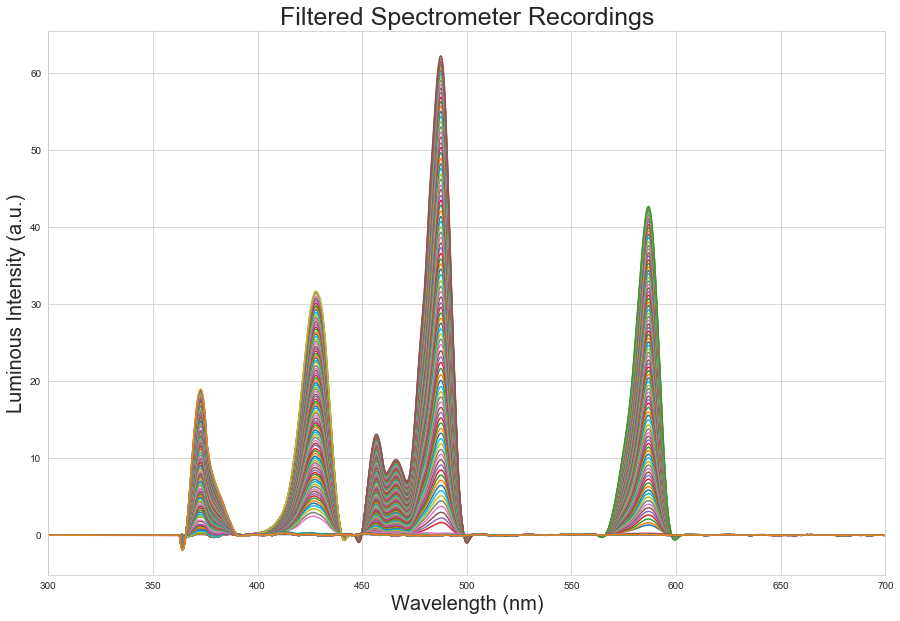

In [34]:
# Use a Savitzky–Golay filter to smooth the recorded "Spectra" traces

savgolWindow = 61   # The length of the filter window
savgolOrder = 2     # The order of the polynomial used to fit the samples.
savgolDelta = 1     # The spacing of the samples to which the filter will be applied.

Smoothed = savgol(Spectra, savgolWindow, savgolOrder, delta = savgolDelta, axis = -1)
Smoothed = Smoothed.reshape(nLED,nPoints,-1)
Smoothed = Smoothed[:,:-7,:]

fig,ax = plt.subplots(1,1,figsize = FigureSize)
[ax.plot(WvsX,Smoothed[0,i,:]) for i in range(Smoothed.shape[1])]
[ax.plot(WvsX,Smoothed[1,i,:]) for i in range(Smoothed.shape[1])]
[ax.plot(WvsX,Smoothed[2,i,:]) for i in range(Smoothed.shape[1])]
[ax.plot(WvsX,Smoothed[3,i,:]) for i in range(Smoothed.shape[1])]

ax.set_title('Filtered Spectrometer Recordings', fontsize = FigureTitleSize)
ax.set_xlabel('Wavelength (nm)', fontsize = FigureFontSize)
ax.set_ylabel('Luminous Intensity (a.u.)', fontsize = FigureFontSize)
ax.set_xlim((SpectraRange))

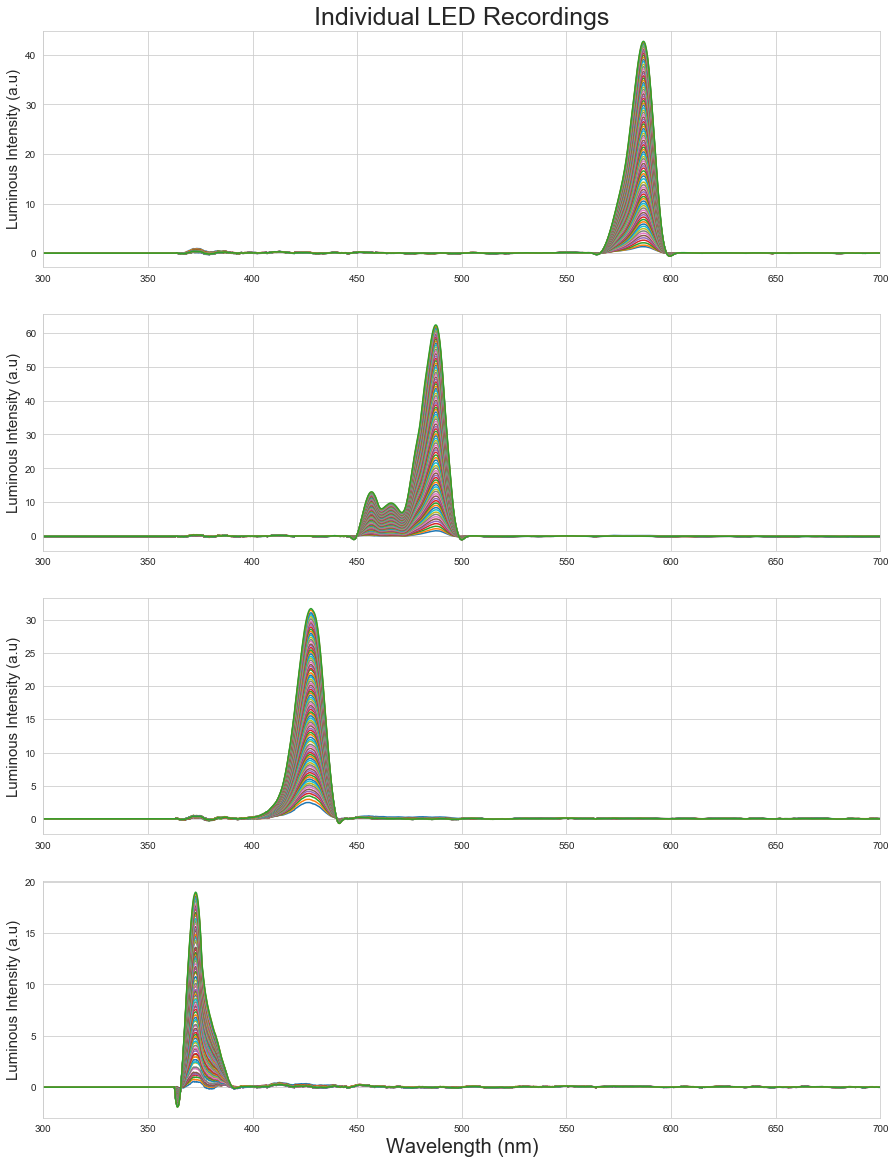

In [35]:
# Plot all recorded LED intensity value individually

fig,ax = plt.subplots(4,1,figsize = (15,20))

[ax[0].plot(WvsX,Smoothed[0,i,:]) for i in range(Smoothed.shape[1])];
[ax[1].plot(WvsX,Smoothed[1,i,:]) for i in range(Smoothed.shape[1])];
[ax[2].plot(WvsX,Smoothed[2,i,:]) for i in range(Smoothed.shape[1])];
[ax[3].plot(WvsX,Smoothed[3,i,:]) for i in range(Smoothed.shape[1])];


[ax[0].set_title('Individual LED Recordings', fontsize = FigureTitleSize)]
[ax[i].set_xlabel('Wavelength (nm)', fontsize = FigureFontSize) for i in [3]]
[ax[i].set_ylabel('Luminous Intensity (a.u)', fontsize = 15) for i in [0,1,2,3]]

[ax[i].set_xlim(SpectraRange) for i in [0,1,2,3]];

In [37]:
# Determine peak wavelength for each LED in nm

sm = 80
MaxesIndices = np.argmax(Smoothed[:,sm,:],axis = -1)

Peaks = WvsX[MaxesIndices]
Peaks = np.around(Peaks,decimals=1)

Peak = [['','Red ','Green ','Blue ','UV '],
        ['Peak Wavelength (nm)',Peaks[0],Peaks[1],Peaks[2],Peaks[3]],
        ]

display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in Peak)
       )
))

,Red,Green,Blue,UV
Peak Wavelength (nm),586.9,487.5,427.9,372.8


In [38]:
# Setting functions and parameters to establish LED performances

def linfunc(x,param):
    a,b = param
    return a+b*x

def linfunc_error(param,x,y):
    """x is current, param is a vector of length 2, y is all luminescence values"""
    y_pred = linfunc(x,param)
    return np.sum((y-y_pred)**2)/y.shape[0]

def norm_ours (myarray):
    myarray = myarray/np.nanmax(np.abs(myarray))
    return myarray

x0 = [1,1] # initial guess for a,b
args = (np.arange(1,94),np.sum(Smoothed[0,:,:],axis=-1))
argss = (np.arange(1,94),np.sum(Smoothed[1,:,:],axis=-1))
argsss = (np.arange(1,94),np.sum(Smoothed[2,:,:],axis=-1))
argssss = (np.arange(1,94),np.sum(Smoothed[3,:,:],axis=-1))


RedSolution = minimize(linfunc_error, x0 = x0, args = args).x
GreenSolution = minimize(linfunc_error, x0 = x0, args = argss).x
BlueSolution = minimize(linfunc_error, x0 = x0, args = argsss).x
UVSolution = minimize(linfunc_error, x0 = x0, args = argssss).x

SSE_Red = np.sqrt(linfunc_error(RedSolution, args[0], args[1]))
SSE_Red = np.around(SSE_Red,decimals=2)
SSE_Green = np.sqrt(linfunc_error(GreenSolution, args[0], args[1]))
SSE_Green = np.around(SSE_Red,decimals=2)
SSE_Blue = np.sqrt(linfunc_error(BlueSolution, args[0], args[1]))
SSE_Blue = np.around(SSE_Red,decimals=2)
SSE_UV = np.sqrt(linfunc_error(UVSolution, args[0], args[1]))
SSE_UV = np.around(SSE_Red,decimals=2)


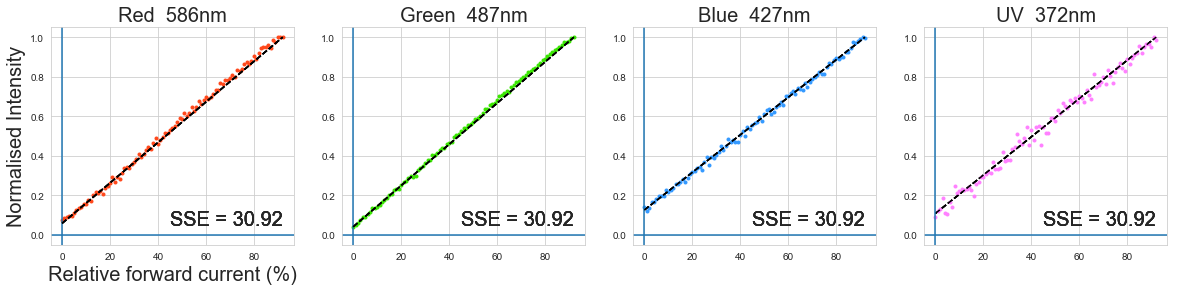

In [39]:
# Plot LEDs intensities (relative output power) against their forward current

fig,ax = plt.subplots(1,nLED,figsize = (20,4))
titles = ['Red  '+str(int(Peaks[0]))+'nm','Green  '+str(int(Peaks[1]))+'nm','Blue  '+str(int(Peaks[2]))+'nm','UV  '+str(int(Peaks[3]))+'nm']
colors = ["#ff471a",'#39e600','#3399ff','#ff80ff']

SSE_Font = 20
SSE_x = 45
SSE_y = 0.05

for i in [0,1,2,3]:
    ax[i].plot(norm_ours(np.sum(Smoothed[i,:,:],axis=-1)),'.',color = colors[i])
    ax[0].plot(norm_ours(linfunc(args[0],RedSolution)),"k--")
    ax[0].text(SSE_x,SSE_y,'SSE = '+str(SSE_Red),fontsize=SSE_Font)
    ax[1].plot(norm_ours(linfunc(args[0],GreenSolution)),"k--")
    ax[1].text(SSE_x,SSE_y,'SSE = '+str(SSE_Green),fontsize=SSE_Font)
    ax[2].plot(norm_ours(linfunc(args[0],BlueSolution)),"k--")
    ax[2].text(SSE_x,SSE_y,'SSE = '+str(SSE_Blue),fontsize=SSE_Font)
    ax[3].plot(norm_ours(linfunc(args[0],UVSolution)),"k--")
    ax[3].text(SSE_x,SSE_y,'SSE = '+str(SSE_UV),fontsize=SSE_Font)
    ax[i].set_title(titles[i], fontsize = FigureFontSize)
    
    ax[0].set_xlabel('Relative forward current (%)', fontsize = FigureFontSize)
    ax[0].set_ylabel('Normalised Intensity', fontsize = FigureFontSize)
    ax[i].axhline()
    ax[i].axvline()

plt.savefig("Normalised Intensity VS Forward Current.png")

C:\Users\Maxime\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


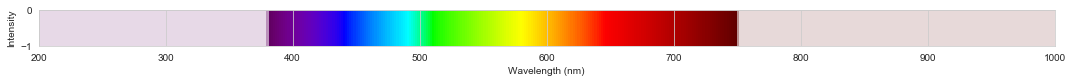

In [9]:
# Setting a "rainbow" gradient that attribute a given wavelentgh (in nm) to its approximate RGB color value

''' This part of the code is taken from http://www.noah.org/wiki/Wavelength_to_RGB_in_Python.

    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    ''' 

def wavelength_to_rgb(wavelength, gamma=0.8):
    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 750:
        A = 1.
    else:
        A=0.15
    if wavelength < 380:
        wavelength = 380.
    if wavelength >750:
        wavelength = 750.
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    return (R,G,B,A)

clim=(350,780)
norm = plt.Normalize(*clim)
wl = np.arange(clim[0],clim[1]+1,2)
colorlist = list(zip(norm(wl),[wavelength_to_rgb(w) for w in wl]))
spectralmap = matplotlib.colors.LinearSegmentedColormap.from_list("spectrum", colorlist)

fig, axs = plt.subplots(1, 1, figsize=(15,1.25), tight_layout=True)

wavelengths = np.linspace(200, 1000, 1000)
spectrum = (5 + np.sin(wavelengths*0.1)**2) * np.exp(-0.00002*(wavelengths-600)**2)
#plt.plot(wavelengths, spectrum, color='darkred')

y = np.linspace(0, -1, 100)
X,Y = np.meshgrid(wavelengths, y)

extent=(np.min(wavelengths), np.max(wavelengths), np.min(y), np.max(y))

plt.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect='auto')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.ylim(-1,0)
plt.fill_between(wavelengths, spectrum,  8, color='w')
plt.savefig('WavelengthColors.png')

plt.show()

(-0.05, 1.01)

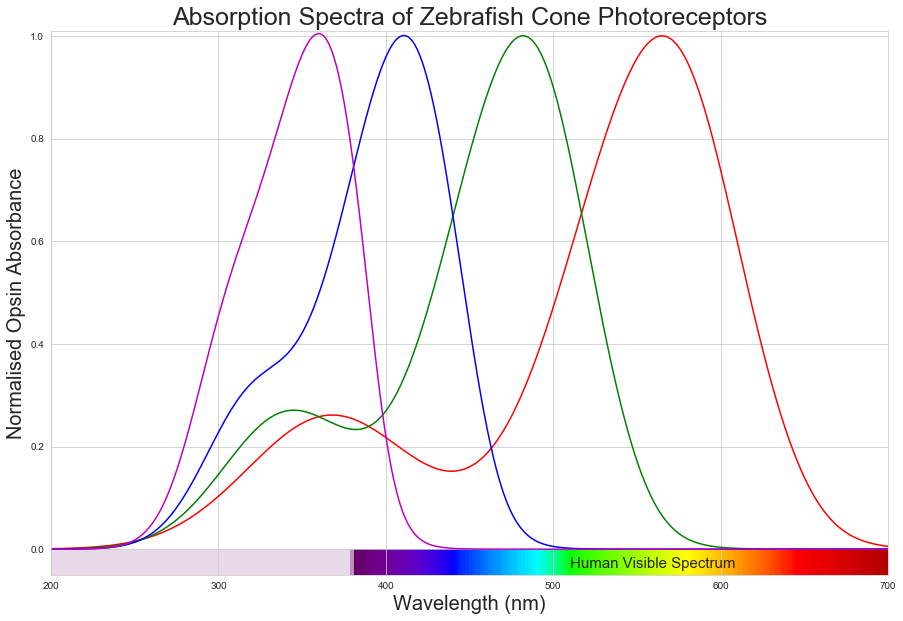

In [10]:
# Plot zebrafish cone opsin absorption spectra

'''This part of the code uses the absorbance spectrum fitting template for visual pigment defined by Govardoskii et al (In 
Search of Visual Pigment Template, 2000).'''

def Govardovskii (wvsloc, lambdamax):
   """Govardovskii 2000 alpha band template. This function returns one sensitivity spectrum point y at wavelength = wvs
   of an opsin  with a peak at lambdamax,
   wvs - such wavelengths at which the template will be evaluated: 1d-array
   lambdamax - peak of the sensitivity spectrum"""
   wvs = np.asarray(wvsloc)
   A = 69.7
   a = 0.8795+0.0459*np.exp(-np.square(lambdamax-300)/11940)
   B = 28
   b = 0.922
   C = -14.9
   c = 1.104
   D = 0.674
   x = lambdamax/wvs
   alphaband = 1/ (np.exp(A*(a-x))+np.exp(B*(b-x))+np.exp(C*(c-x))+D)
   
   #####BETABAND######
   Ab = 0.26 #Beta value at peak
   b = -40.5+0.195*lambdamax #Beta bandwidth
   Lamb = 189+0.315*lambdamax #Beta peak
   betaband = Ab * np.exp(-1*((wvs-Lamb)/b)**2)
   return alphaband+betaband


red = Govardovskii(WvsX,peakwvss[0])
green = Govardovskii(WvsX,peakwvss[1])
blue = Govardovskii(WvsX,peakwvss[2])
uv = Govardovskii(WvsX,peakwvss[3])

fig,ax = plt.subplots(1,1,figsize = FigureSize)
ax.plot(WvsX,red,c='r')
ax.plot(WvsX,green,c='g')
ax.plot(WvsX,blue,c='b')
ax.plot(WvsX,uv,c='m')

ax.set_title('Absorption Spectra of Zebrafish Cone Photoreceptors', fontsize = FigureTitleSize)
ax.set_xlabel('Wavelength (nm)', fontsize = FigureFontSize)
ax.set_ylabel('Normalised Opsin Absorbance', fontsize = FigureFontSize)

ax.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
plt.text(510, -0.0375, 'Human Visible Spectrum', fontsize=15)

ax.set_xlim(SpectraRange)
ax.set_ylim(-0.05,1.01)

(-0.05, 1.01)

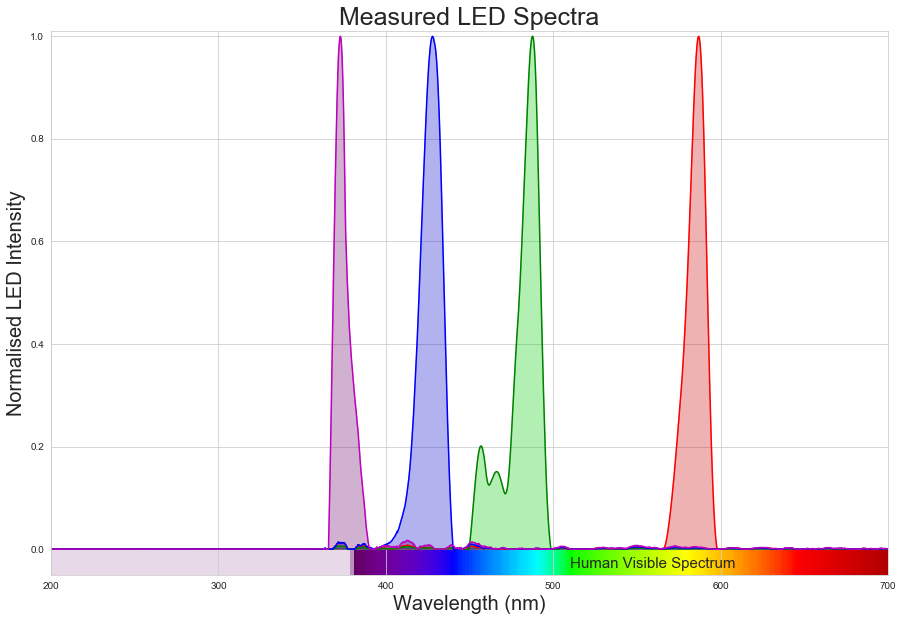

In [11]:
# Plot LED spectra

RedLEDNormalised = Smoothed[0,sm,:]/np.amax(Smoothed[0,sm,:])
GreenLEDNormalised = Smoothed[1,sm,:]/np.amax(Smoothed[1,sm,:])
BlueLEDNormalised = Smoothed[2,sm,:]/np.amax(Smoothed[2,sm,:])
UVLEDNormalised = Smoothed[3,sm,:]/np.amax(Smoothed[3,sm,:])

RedLEDnormalised = np.copy(RedLEDNormalised)
RedLEDnormalised[RedLEDnormalised<0] = 0
GreenLEDnormalised = np.copy(GreenLEDNormalised)
GreenLEDnormalised[GreenLEDnormalised<0] = 0
BlueLEDnormalised = np.copy(BlueLEDNormalised)
BlueLEDnormalised[BlueLEDnormalised<0] = 0
UVLEDnormalised = np.copy(UVLEDNormalised)
UVLEDnormalised[UVLEDnormalised<0] = 0

fig,ax = plt.subplots(1,1,figsize = FigureSize)
ax.plot(WvsX,RedLEDnormalised,'r')
ax.fill(WvsX,RedLEDnormalised, c = (0.8,0.0,0.0,0.3))
ax.plot(WvsX,GreenLEDnormalised,'g')
ax.fill(WvsX,GreenLEDnormalised, c = (0.0,0.8,0.0,0.3))
ax.plot(WvsX,BlueLEDnormalised,'b')
ax.fill(WvsX,BlueLEDnormalised, c = (0.0,0.0,0.8,0.3))
ax.plot(WvsX,UVLEDnormalised,'m')
ax.fill(WvsX,UVLEDnormalised, c = (0.4,0.0,0.4,0.3))

ax.set_title('Measured LED Spectra', fontsize = FigureTitleSize)
ax.set_xlabel('Wavelength (nm)', fontsize = FigureFontSize)
ax.set_ylabel('Normalised LED Intensity', fontsize = FigureFontSize)

ax.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
plt.text(510, -0.0375, 'Human Visible Spectrum', fontsize=15)

ax.set_xlim(SpectraRange)
ax.set_ylim(-0.05,1.01)

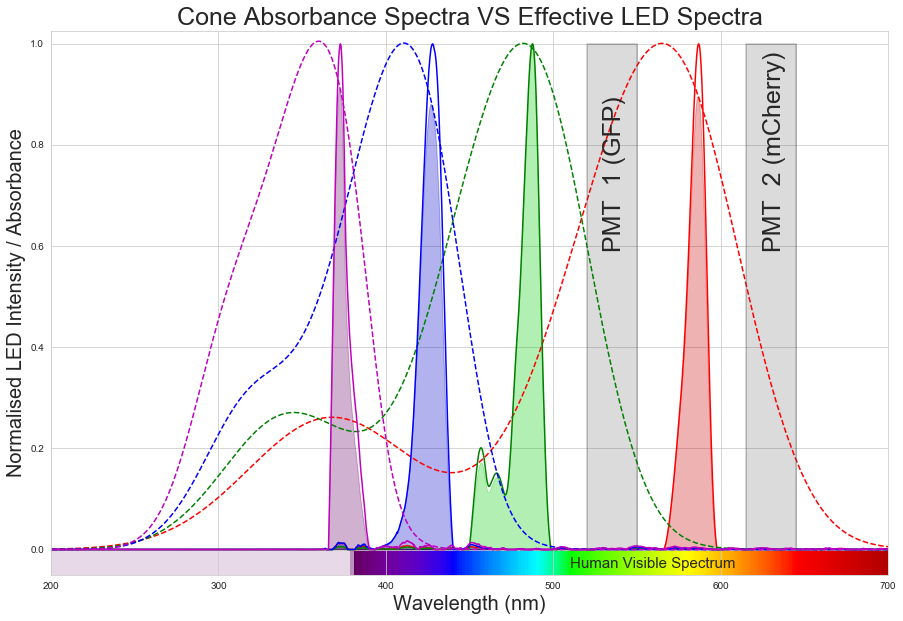

In [12]:
# Plot LED spectra against the zebrafish cone action spectra. Graph includes the PMT detector bands

fig,ax = plt.subplots(1,1,figsize = FigureSize)


RedLEDnormalised = np.copy(RedLEDNormalised)
RedLEDnormalised[RedLEDnormalised<0] = 0
GreenLEDnormalised = np.copy(GreenLEDNormalised)
GreenLEDnormalised[GreenLEDnormalised<0] = 0
BlueLEDnormalised = np.copy(BlueLEDNormalised)
BlueLEDnormalised[BlueLEDnormalised<0] = 0
UVLEDnormalised = np.copy(UVLEDNormalised)
UVLEDnormalised[UVLEDnormalised<0] = 0

ax.plot(WvsX,red,'r--')
ax.plot(WvsX,RedLEDnormalised,'r')
ax.fill(WvsX,np.multiply(red,RedLEDnormalised), c = (0.8,0.0,0.0,0.3))

ax.plot(WvsX,green,'g--')
ax.plot(WvsX,GreenLEDnormalised,'g')
ax.fill(WvsX,np.multiply(green,GreenLEDnormalised), c = (0.0,0.8,0.0,0.3))

ax.plot(WvsX,blue,'b--')
ax.plot(WvsX,BlueLEDnormalised,'b')
ax.fill(WvsX,np.multiply(blue,BlueLEDnormalised), c = (0.0,0.0,0.8,0.3))

ax.plot(WvsX,uv,'m--')
ax.plot(WvsX,UVLEDnormalised,'m')
ax.fill(WvsX,np.multiply(uv,UVLEDnormalised), c = (0.4,0.0,0.4,0.3))

ax.set_xlim(SpectraRange)
ax.set_ylim(-0.05,1.025)

plt.plot([PMT1_min,PMT1_min,PMT1_max,PMT1_max], [0,1,1,0], c = (0.3,0.3,0.3,0.3))
ax.fill([PMT1_min,PMT1_min,PMT1_max,PMT1_max], [0,1,1,0], c = (0.3,0.3,0.3,0.2))
plt.text(PMT1_min+10, 0.66+0.2, 'PMT  1 (GFP)', fontsize=25, rotation=90)

plt.plot([PMT2_min,PMT2_min,PMT2_max,PMT2_max], [0,1,1,0], c = (0.3,0.3,0.3,0.3))
ax.fill([PMT2_min,PMT2_min,PMT2_max,PMT2_max], [0,1,1,0], c = (0.3,0.3,0.3,0.2))
plt.text(PMT2_min+10, 0.749+0.2, 'PMT  2 (mCherry)', fontsize=25, rotation=90)

ax.set_title('Cone Absorbance Spectra VS Effective LED Spectra', fontsize = FigureTitleSize)
plt.xlabel('Wavelength (nm)', fontsize = FigureFontSize)
plt.ylabel('Normalised LED Intensity / Absorbance', fontsize = FigureFontSize)

ax.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
plt.text(510, -0.0375, 'Human Visible Spectrum', fontsize=15)

plt.savefig("Opsin-LED Spectra.png")

In [13]:
#This code does several things:
#1. Fits Govardovskii (A1) templates to desired peak wavelengths: Ops
#2. Calculates M and N matrices for silent substitution: M, N
#3. Calculates the number of photoisomerisations for desired LED settings: isonum
#4. Calculates the LED settings for desired number of photoisomerisations: LEDchange

nCone = nLED

Led = np.zeros((1025, nLED))
for jj in range (0,nLED):
    Led = [RedLEDnormalised,GreenLEDnormalised,BlueLEDnormalised,UVLEDnormalised]

Led = np.asarray(Led).T
    
    
##Variables for photoisomerisation calculation
lightspot = 300**2*np.pi#area of the lightspot (um2)

ledmaxima = np.asarray((np.argmax(Led[:,0]),np.argmax(Led[:,1]),np.argmax(Led[:,2]),np.argmax(Led[:,3])))/ 1000000000 #checking the maxima of led spectra
    
gamma = 0.67 # p(photoisomerisation/Light being absorbed) '''dowling 1967ish'''

OSD = np.asarray([2.4, 2.4, 2.8, 2.6], dtype = np.float64) # Outer segment Diameter, RGBU, Allison (um)

OSA = (OSD[:]/2)**2*np.pi

OSL = [10, 10, 7.6, 10] #Outer segment length, Branchek 1984, broadly agree with my measurements (um)
#these numbers are taken to be average light pathlengths, which is important
# for isomrisations number calculation. Depending on cone shape, these may need to be
# divided by some number between 1 and 3, since the diameter of the peak of the cone is not 0.

specabs = [0.0073, 0.0063, 0.007, 0.0054] #specific absorbance RGBU (um-1), from Allison et al

pmre = np.asarray([100,100,100,100]) #powermeter readings, (nW)

lgf = 1 #light-guided factor OR light polarisation factor - dunno, if illuminating OS directly,
# it's just a linear factor that is the same for all cones. Therefore, don't care much.

DesiredISOs = np.asarray([260000,260000,260000,260000]) #desired number of isomerisations per cone, RGBU

########## VARIABLES END ############

Ops = np.asarray([Govardovskii (WvsX, Peaks[i]) for i in [0,1,2,3]])
Ops = Ops.swapaxes(1,0)

################################################################

#extracting the data BGRU
#dummy 25 elements to satisfy conditions for romb integration


#calculate the wvs-dependent photon energy
def photonenergy(wvs):
    Qev = 299792458 * 4.135667*10**(-15) / wvs
    return Qev

def photoflux(powermeter_reading,wvs, lightspot): #photon flux density (um-2s-1)
    flux = powermeter_reading/1000000000*6.24*10**18 / photonenergy(wvs) / lightspot
    return flux
    
def readingsfromflux(fluxe,wvs, lightspot): #get desired power from flux - needed to calculate grey level
    readings = fluxe*lightspot*photonenergy(wvs)*1000000000/(6.24*10**18)
    return readings

#2.303 is a factor used to convert log10 to ln. 2.303logX=lnX (i.e., not needed here).
#Allison et al calculate specific absorbance
# (specabs) as (log10 T^-1)/OSD diameter, because they were shining light transversely. 

def isomerisation(M1e, pmre, lednum, OSA,OSL, conen, gamma, lgf, specabs, lightspot, wvss):
    iso = M1e * OSA[conen] * lgf *  gamma * (1-10**(-specabs[conen]*OSL[conen]))
    return iso
    
fluxe = photoflux(pmre, ledmaxima, lightspot)


#M0 is needed to take integrals over LED*OPS
#M1 is the M matrix of Estevez, gives vector of response changes (r) from vector of stimulus changes (s): r = M1*s
#Mforabs is like M1 where s is flux per LED and r is absolute photoisomerisations number per cone

M0 = np.zeros((nCone,nLED, len(Led[:,0])))
M =np.zeros((nCone,nLED))
M1ef=np.zeros((nCone,nLED))

Mforabs =np.zeros((nCone,nLED))

for k in range(0,(nLED)): #k is conenumber, j is lednumber
    for j in range(0,(nLED)):
        M0[k,j,:] = Ops[:,k]*Led[:,j]
        M[k,j] = np.sum(M0[k,j,:]) #different columns are different LEDs
        M1ef[k,j] = M[k,j]/np.sum(Led[:,j])
        Mforabs[k,j] = isomerisation(M1ef[k,j], pmre, j, OSA, OSL, k, gamma, lgf, specabs, lightspot, ledmaxima)#matrix that translates flux into isomerisations
        
N = np.linalg.inv(M)# inverse of M1

isonum = np.dot(Mforabs,fluxe)#absolute number of photoisomerisations in cones
N1ISO = np.linalg.inv(Mforabs)# inverse of Mforabs

### getting LED settings needed for desired isomerisations

LEDchange = readingsfromflux(np.dot(N1ISO,DesiredISOs), ledmaxima, lightspot) #LED output in nW that produces the desired isomerisations, RGBU
fluxe2= photoflux(LEDchange, ledmaxima, lightspot)


In [26]:
M_Matrix = norm_ours(M)
vmx = np.amax(np.abs(M_Matrix.reshape(-1)))
vmn = - vmx

N_Matrix = norm_ours(N)
vnx = np.amax(np.abs(N_Matrix.reshape(-1)))
vnn = - vnx

NIso_Matrix = norm_ours(N1ISO)
vnix = np.amax(np.abs(NIso_Matrix.reshape(-1)))
vnin = - vnix


DataM = np.around(M_Matrix,decimals=2)
DataN = np.around(N_Matrix,decimals=2)
DataNIso = np.around(NIso_Matrix,decimals=2)


dataM = [['M Matrix','  Red Opsin  ','  Green Opsin  ','  Blue Opsin  ','  UV Opsin  '],
        ['Red LED',DataM[0,0],DataM[0,1],DataM[0,2],DataM[0,3]],
        ['Green LED',DataM[1,0],DataM[1,1],DataM[1,2],DataM[1,3]],
        ['Blue LED',DataM[2,0],DataM[2,1],DataM[2,2],DataM[2,3]],
        ['UV LED',DataM[3,0],DataM[3,1],DataM[3,2],DataM[3,3]],
        ]

dataN = [['N Matrix','  Red Opsin  ','  Green Opsin  ','  Blue Opsin  ','  UV Opsin  '],
        ['Red LED',DataN[0,0],DataN[0,1],DataN[0,2],DataN[0,3]],
        ['Green LED',DataN[1,0],DataN[1,1],DataN[1,2],DataN[1,3]],
        ['Blue LED',DataN[2,0],DataN[2,1],DataN[2,2],DataN[2,3]],
        ['UV LED',DataN[3,0],DataN[3,1],DataN[3,2],DataN[3,3]],
        ]

dataNIso = [['NIso Matrix','  Red Opsin  ','  Green Opsin  ','  Blue Opsin  ','  UV Opsin  '],
        ['Red LED',DataNIso[0,0],DataNIso[0,1],DataNIso[0,2],DataNIso[0,3]],
        ['Green LED',DataNIso[1,0],DataNIso[1,1],DataNIso[1,2],DataNIso[1,3]],
        ['Blue LED',DataNIso[2,0],DataNIso[2,1],DataNIso[2,2],DataNIso[2,3]],
        ['UV LED',DataNIso[3,0],DataNIso[3,1],DataNIso[3,2],DataNIso[3,3]],
        ]

display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in dataM),
       )
))
display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in dataN)
       )
))
display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in dataNIso)
       )
))


M Matrix,Red Opsin,Green Opsin,Blue Opsin,UV Opsin
Red LED,0.83,0.21,0.19,0.2
Green LED,0.03,1.0,0.44,0.18
Blue LED,0.01,0.27,1.0,0.34
UV LED,0.01,0.0,0.09,0.67


N Matrix,Red Opsin,Green Opsin,Blue Opsin,UV Opsin
Red LED,0.77,-0.15,-0.07,-0.15
Green LED,-0.02,0.73,-0.32,-0.02
Blue LED,-0.0,-0.2,0.76,-0.34
UV LED,-0.01,0.02,-0.1,1.0


NIso Matrix,Red Opsin,Green Opsin,Blue Opsin,UV Opsin
Red LED,0.77,-0.17,-0.07,-0.17
Green LED,-0.03,1.0,-0.37,-0.03
Blue LED,-0.0,-0.28,0.9,-0.45
UV LED,-0.01,0.02,-0.09,0.96


In [17]:
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Arguments:
        data       : A 2D numpy array of shape (N,M)
        row_labels : A list or array of length N with the labels
                     for the rows
        col_labels : A list or array of length M with the labels
                     for the columns
    Optional arguments:
        ax         : A matplotlib.axes.Axes instance to which the heatmap
                     is plotted. If not provided, use current axes or
                     create a new one.
        cbar_kw    : A dictionary with arguments to
                     :meth:`matplotlib.Figure.colorbar`.
        cbarlabel  : The label for the colorbar
    All other arguments are directly passed on to the imshow call.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels,fontsize=FigureFontSize)
    ax.set_yticklabels(row_labels,fontsize=FigureFontSize)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True, left = True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right",rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",textcolors=["black", "black"],threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Arguments:
        im         : The AxesImage to be labeled.
    Optional arguments:
        data       : Data used to annotate. If None, the image's data is used.
        valfmt     : The format of the annotations inside the heatmap.
                     This should either use the string format method, e.g.
                     "$ {x:.2f}", or be a :class:`matplotlib.ticker.Formatter`.
        textcolors : A list or array of two color specifications. The first is
                     used for values below a threshold, the second for those
                     above.
        threshold  : Value in data units according to which the colors from
                     textcolors are applied. If None (the default) uses the
                     middle of the colormap as separation.

    Further arguments are passed on to the created text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[im.norm(data[i, j]) > threshold])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

C:\Users\Maxime\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


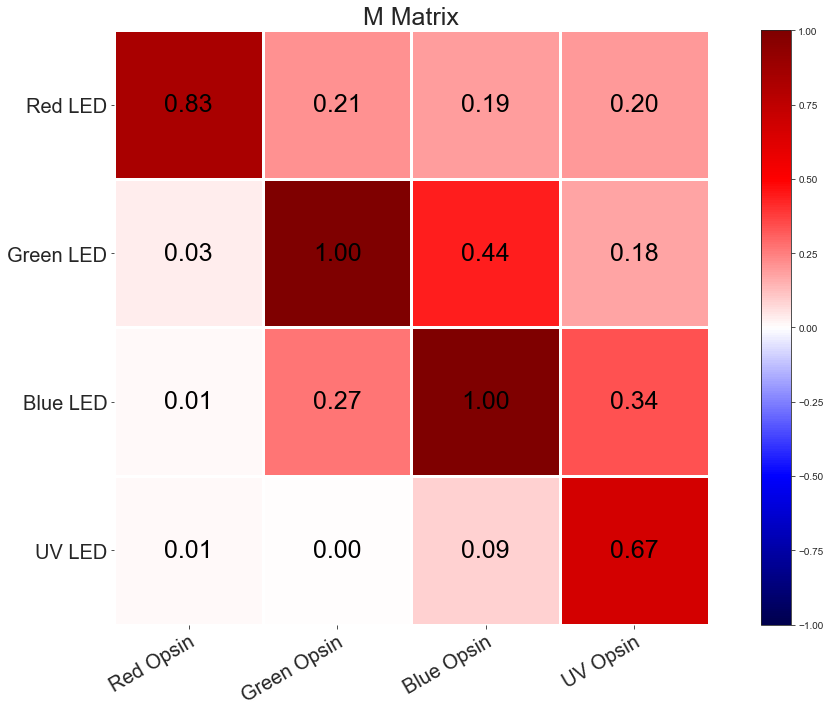

In [21]:
Cones = ["Red Opsin", "Green Opsin", "Blue Opsin", "UV Opsin"]
LEDs = ["Red LED", "Green LED", "Blue LED","UV LED"]

# We want to show all ticks...
ax.set_xticks(np.arange(len(Cones)))
ax.set_yticks(np.arange(len(LEDs)))
# ... and label them with the respective list entries
ax.set_xticklabels(Cones)
ax.set_yticklabels(LEDs)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="left",rotation_mode="anchor")
sns.set_style("white")

fig, (ax1) = plt.subplots(1, 1, figsize=FigureSize)

im, _ = heatmap(M_Matrix, LEDs, Cones, ax=ax1, cmap="seismic", vmax = vmx, vmin = vmn)
annotate_heatmap(im, valfmt="{x:.2f}", size=FigureFontSize+5)

ax1.set_title('M Matrix', fontsize = FigureTitleSize)

fig.tight_layout()
plt.savefig("M Matrix.png")

C:\Users\Maxime\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


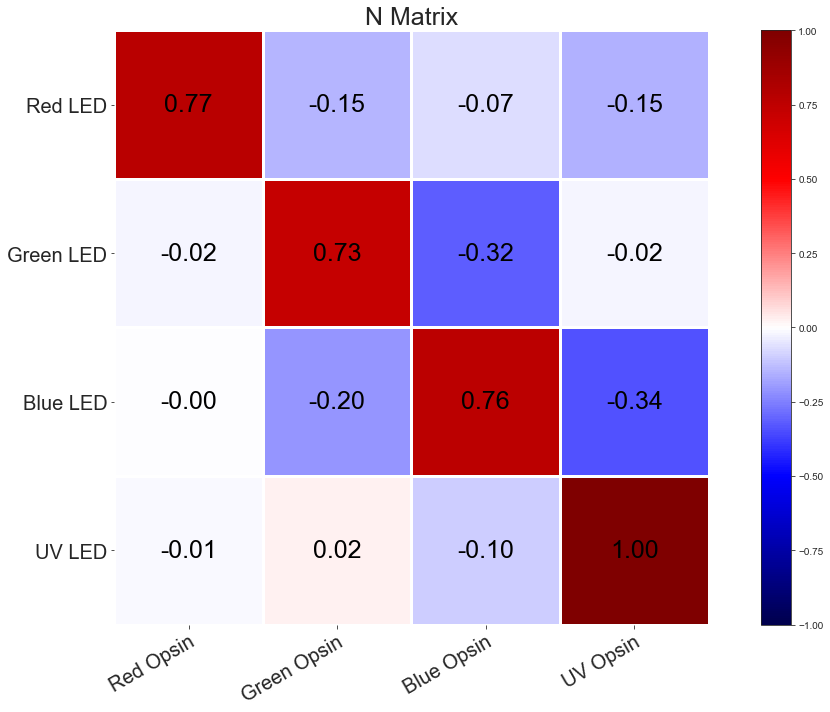

In [19]:
fig, (ax2) = plt.subplots(1, 1, figsize=FigureSize)
sns.set_style("white")

im, _ = heatmap(N_Matrix, LEDs, Cones, ax=ax2, cmap="seismic", vmax = vnx, vmin = vnn)
annotate_heatmap(im, valfmt="{x:.2f}", size=FigureFontSize+5)

ax2.set_title('N Matrix', fontsize = FigureTitleSize)

fig.tight_layout()
plt.savefig("N Matrix.png")

C:\Users\Maxime\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


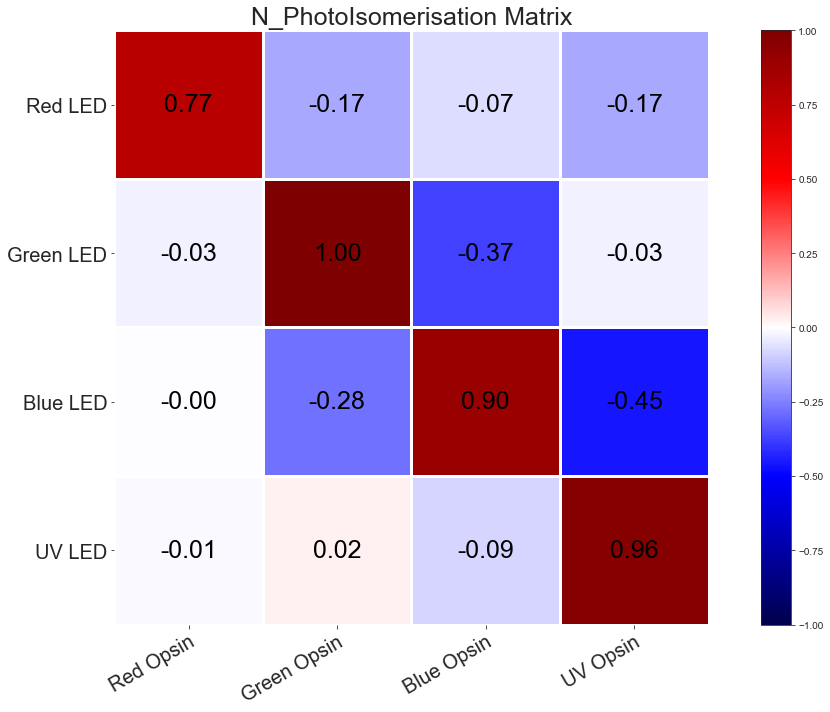

In [20]:
fig, (ax2) = plt.subplots(1, 1, figsize=FigureSize)
sns.set_style("white")

im, _ = heatmap(NIso_Matrix, LEDs, Cones, ax=ax2, cmap="seismic", vmax = vnix, vmin = vnin)
annotate_heatmap(im, valfmt="{x:.2f}", size=FigureFontSize+5)

ax2.set_title('N_PhotoIsomerisation Matrix', fontsize = FigureTitleSize)

fig.tight_layout()
plt.savefig("N_PhotoIsomerisation Matrix.png")